# Progress report 2022-06-20
Daniel Mishler

- Someone push my patch to github?
- question: you can run things like jupyter on other machines?
- Tilesize investigation
    - The magic number is 170
    - But we just don't punch through ~84% MKL
    - Other information might lead us closer, but this might not be it...
- Trace tool:
    - Handles POTRF now (other notebook!)
        - POTRF Scheduler analysis on other notebook
        - Still needs some work for the subtasks
        - Start, end times on the larger, recursive tasks on HICMA are not honest
    - Core switching GEMM
        - Core swaps a *lot*
        - Did not pay mind to NUMA nodes yet, but might do

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import parsec_animation_utils as panimate

In [3]:
from matplotlib.animation import FuncAnimation
from IPython import display
plt.ioff()

## Tilesize investigation

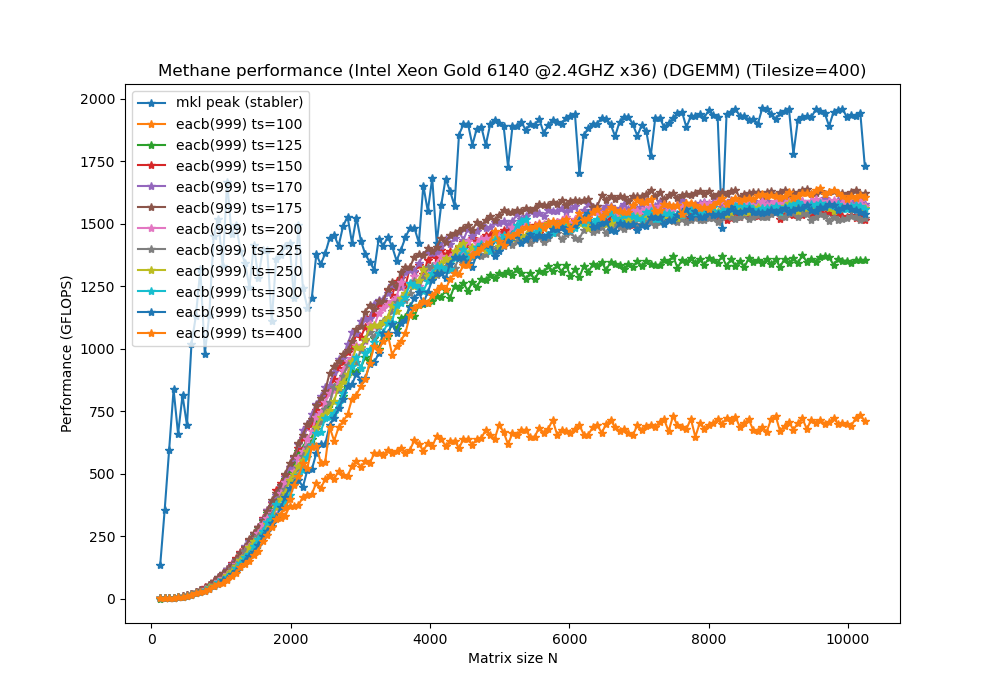

In [4]:
dgemm_methane_peak_stable = pd.read_csv("2022-06-14_36_core_peak_test.csv")
plt.ioff()
tilesizes = [100, 125, 150, 170, 175, 200, 225, 250, 300, 350, 400]
dgemm_methane_eacb_999 = {}

plt.figure(figsize = [10,7])
for tilesize in tilesizes:
    dgemm_methane_eacb_999[tilesize] = pd.read_csv("2022-06-14_eacb999_ts%d_rectangle.csv"% tilesize)

plt.plot(dgemm_methane_peak_stable["N"],    dgemm_methane_peak_stable["GFLOPS"],    "*-", label = "mkl peak (stabler)")
for tilesize in tilesizes:
    plt.plot(dgemm_methane_eacb_999[tilesize]["N"],
             dgemm_methane_eacb_999[tilesize]["GFLOPS"],
             "*-", label = "eacb(999) ts=%d" % tilesize)
# plt.plot([4800,4800], [0,2000], "--", label="today's observed N")

plt.title("Methane performance (Intel Xeon Gold 6140 @2.4GHZ x36) (DGEMM) (Tilesize=%03d)"%tilesize)
plt.legend()
plt.xlabel("Matrix size N")
plt.ylabel("Performance (GFLOPS)")
fname = '2022-06-14_methane_trace_performance_investigation'
plt.savefig(fname + '.svg')
plt.savefig(fname + '.pdf')
plt.savefig(fname + '.png')
display.Image(fname+'.png')

In [5]:
dgemm_mkl_peak = max(dgemm_methane_peak_stable["GFLOPS"])
tilesizemax = []
for tilesize in tilesizes:
    tilesizemax.append(max(dgemm_methane_eacb_999[tilesize]["GFLOPS"]))
dgemm_dplasma_peak = max(tilesizemax)
peak_utilization = dgemm_dplasma_peak/dgemm_mkl_peak
print("We do about %f%s as well as mkl" % (peak_utilization*100, "%"))

We do about 83.837644% as well as mkl


## Trace visualization

In [6]:
trace_potrf     = pd.HDFStore("2022-06-15_mid_dpotrf.prof.h5")
trace_eacb144   = pd.HDFStore("eacb144_profile.prof.h5")
trace_omritest  = pd.HDFStore("dpotrf_tlr.2.90000.3600.2x2.mvapich2.13358284.h5")
trace_ptg_dgemm = pd.HDFStore("dgemm_ptg_trace.prof.h5")

In [7]:
# trace_omritest.event_types

In [8]:
trace_omritest.events.columns

Index(['id', 'type', 'info', 'dc_key', 'taskpool_id', 'dc_dataid', 'begin',
       'k', 'stream_id', 'size', 'trc', 'm', 'rd_fid', 'node_id', 'n', 'tcid',
       'flags', 'end', 'sde:::PARSEC::SCHEDULER::PENDING_TASKS_start',
       'sde:::PARSEC::SCHEDULER::PENDING_TASKS', 'src', 'dst', 'tpid', 'dep',
       'tid'],
      dtype='object')

### Analyzing with hwloc-ls

In [9]:
"""
myfile = open("test_trace_info.txt", "w")
myfile.write(trace_potrf.information["HWLOC-XML"])
myfile.close()
"""
# With more time, I might be able to integrate NUMA node knowledge with stream_id

'\nmyfile = open("test_trace_info.txt", "w")\nmyfile.write(trace_potrf.information["HWLOC-XML"])\nmyfile.close()\n'

### POTRF

In [10]:
panimate.animate_trace(trace_potrf,
                     "potrf",
                     which_animate = "progress",
                     title = "potrf trace testing",
                     num_frames = 30,
                     fps = 10,
                     N = 5400,
                     M = 5400,
                     K = 5400,
                     tilesize = 180)

Beginning animation of data 'potrf trace testing' method 'progress'
After observing your trace, I am guessing it is from the ptg interface
I think this trace is for a task that was running on dplasma
found task type potrf_dgemm (#17)
found task type potrf_dsyrk (#18)
found task type potrf_dtrsm (#19)
found task type potrf_dpotrf (#20)
checking work tasks uniqueness
checking index and preparing work tasks for  17
time for array prep:   0.1374974250793457
checking index and preparing work tasks for  18
time for array prep:   0.16112184524536133
checking index and preparing work tasks for  19
time for array prep:   0.18979907035827637
checking index and preparing work tasks for  20
time for array prep:   0.17141509056091309
done checking uniqueness. Building order dataframe
process runtime per frame: 0.002300 seconds
estimated execution time (assuming a lightweight commercial processor): 10.800000 seconds


Data titled 'potrf trace testing'
M=5400,	N=5400,	K=5400,	tilesize=180
average task execution time: 0.331854
task execution time standard deviation: 0.494324
utilization: 23.851412 over 36 cores (0.662539)
execution time to generate graphs: 2.724116 seconds
execution time to preprocess data: 1.291666 seconds
execution time total: 4.015782 seconds
saved task metadata file: tasks_per_frame_(potrf trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf trace testing).png
saved task metadata file: tasks_times_sorted_(potrf trace testing).png



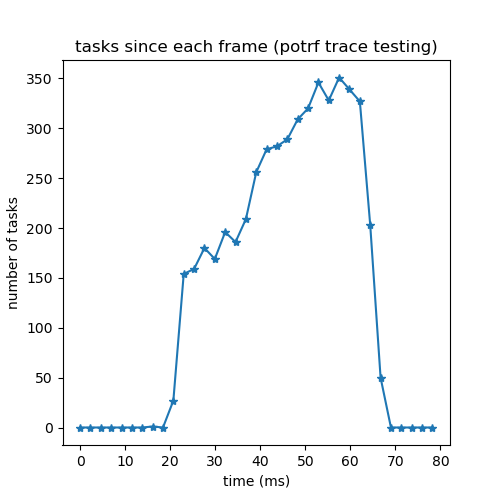

In [11]:
display.Image("tasks_per_frame_(potrf trace testing).png")

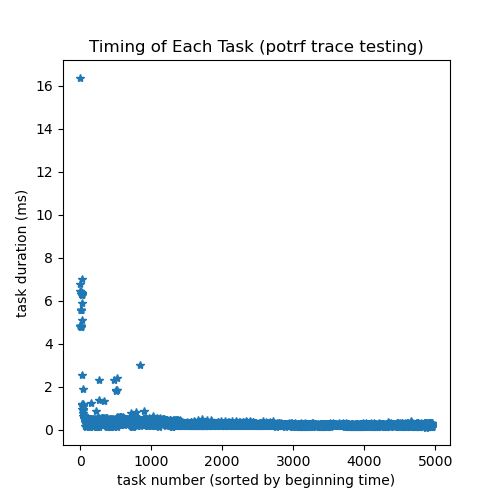

In [12]:
display.Image("tasks_times_execution_order_(potrf trace testing).png")

In [13]:
panimate.animate_trace(trace_omritest,
                     "potrf",
                     which_animate = "progress",
                     title = "potrf tiled trace testing",
                     num_frames = 50,
                     fps = 14,
                     N = 90000,
                     M = 90000,
                     K = 90000,
                     tilesize = 300,
                     bigtilesize = 3600)

Beginning animation of data 'potrf tiled trace testing' method 'progress'
After observing your trace, I am guessing it is from the ptg interface
I think this trace is for a task that was running on hicma
found task type hicma_dpotrf_l_3flow::potrf_dgemm (#23)
found task type hicma_dpotrf_l_3flow::potrf_dsyrk (#24)
found task type hicma_dpotrf_l_3flow::potrf_dtrsm (#25)
found task type hicma_dpotrf_l_3flow::potrf_dpotrf (#26)
found task type dpotrf_l::potrf_dgemm (#30)
found task type dpotrf_l::potrf_dsyrk (#31)
found task type dpotrf_l::potrf_dtrsm (#32)
found task type dpotrf_l::potrf_dpotrf (#33)
checking work tasks uniqueness
checking index and preparing work tasks for  23
time for array prep:   0.8821654319763184
checking index and preparing work tasks for  24
time for array prep:   0.8642482757568359
checking index and preparing work tasks for  25
time for array prep:   0.8610761165618896
checking index and preparing work tasks for  26
time for array prep:   0.865837812423706
chec

id                                                           0
type                                                        33
info                                                         0
dc_key                                          23455577695552
taskpool_id                                                  5
dc_dataid                                                    0
begin                                               1542406279
k                                                            0
stream_id                                                   92
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      2
n                                                         None
tcid                                                   

id                                                           0
type                                                        33
info                                                         0
dc_key                                          23454990488480
taskpool_id                                                  6
dc_dataid                                                    0
begin                                               2109409386
k                                                            0
stream_id                                                   47
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      2
n                                                         None
tcid                                                   

id                                                           0
type                                                        33
info                                                         0
dc_key                                          23454374573360
taskpool_id                                                  7
dc_dataid                                                    0
begin                                               2607100274
k                                                            0
stream_id                                                   58
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      2
n                                                         None
tcid                                                   

id                                                           0
type                                                        33
info                                                         0
dc_key                                          23454308731296
taskpool_id                                                  8
dc_dataid                                                    0
begin                                               2969000496
k                                                            0
stream_id                                                  119
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      1
n                                                         None
tcid                                                   

id                                                           0
type                                                        33
info                                                         0
dc_key                                          23455636415104
taskpool_id                                                  9
dc_dataid                                                    0
begin                                               3456297195
k                                                            0
stream_id                                                   54
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      1
n                                                         None
tcid                                                   

id                                                           4
type                                                        33
info                                                         0
dc_key                                          23455334444960
taskpool_id                                                 10
dc_dataid                                                   52
begin                                               3846958419
k                                                            4
stream_id                                                   10
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      0
n                                                         None
tcid                                                   

id                                                           9
type                                                        33
info                                                         0
dc_key                                          23455057600704
taskpool_id                                                 10
dc_dataid                                                  117
begin                                               4232106920
k                                                            9
stream_id                                                  109
size                                                      None
trc                                                          0
m                                                         None
rd_fid                                                    None
node_id                                                      3
n                                                         None
tcid                                                   

Data titled 'potrf tiled trace testing'
M=90000,	N=90000,	K=90000,	tilesize=300
average task execution time: 6.248432
task execution time standard deviation: 10.369343
utilization: 23.322200 over 127 cores (0.183639)
execution time to generate graphs: 67.450240 seconds
execution time to preprocess data: 10.591313 seconds
execution time total: 78.041553 seconds
saved task metadata file: tasks_per_frame_(potrf tiled trace testing).png
saved task metadata file: tasks_times_execution_order_(potrf tiled trace testing).png
saved task metadata file: tasks_times_sorted_(potrf tiled trace testing).png
error: expected 4545100 tasks but I only observed 12025 in the trace



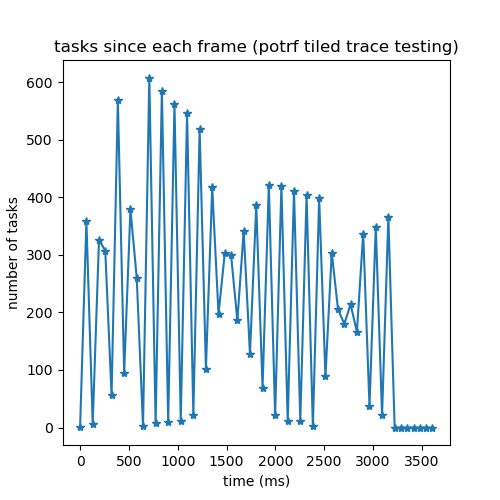

In [14]:
display.Image("tasks_per_frame_(potrf tiled trace testing).png")

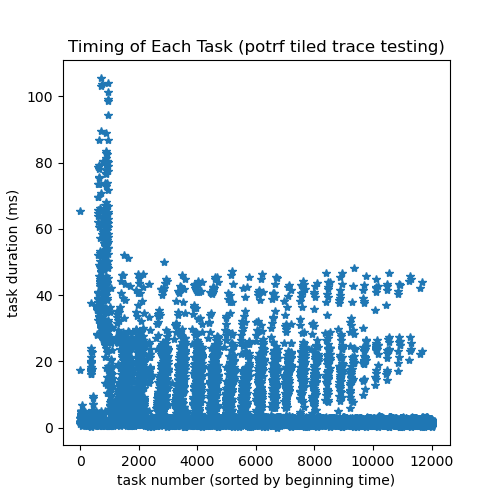

In [15]:
display.Image("tasks_times_execution_order_(potrf tiled trace testing).png")

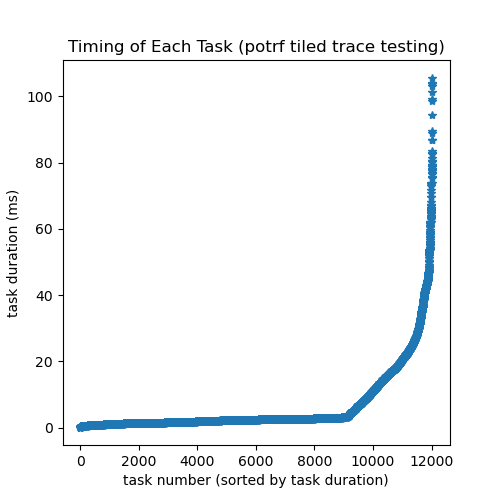

In [16]:
display.Image("tasks_times_sorted_(potrf tiled trace testing).png")

In [17]:
panimate.animate_trace(trace_eacb144,
                     "gemm",
                     panimate.rectangle_order_generator_improved,
                     which_animate = "abcprogress",
                     title = "enforced rectangle eacb 144",
                     num_frames = 60,
                     fps = 10,
                     N = 4800,
                     M = 4800,
                     K = 4800,
                     tilesize = 200)

Beginning animation of data 'enforced rectangle eacb 144' method 'abcprogress'
After observing your trace, I am guessing it is from the dtd interface
I think this trace is for a task that was running on dplasma
checking work tasks uniqueness
checking index and preparing work tasks for  19
time for array prep:   0.5854716300964355
done checking uniqueness. Building order dataframe
process runtime per frame: 0.002677 seconds
estimated execution time (assuming a lightweight commercial processor): 41.472000 seconds


Data titled 'enforced rectangle eacb 144'
M=4800,	N=4800,	K=4800,	tilesize=200
average task execution time: 0.390608
task execution time standard deviation: 0.581035
utilization: 33.616802 over 36 cores (0.933800)
execution time to generate graphs: 17.992183 seconds
execution time to preprocess data: 11.899921 seconds
execution time total: 29.892104 seconds
saved task metadata file: tasks_per_frame_(enforced rectangle eacb 144).png
saved task metadata file: tasks_times_execution_order_(enforced rectangle eacb 144).png
saved task metadata file: tasks_times_sorted_(enforced rectangle eacb 144).png



In [18]:
panimate.animate_trace(trace_eacb144,
                     "gemm",
                     panimate.rectangle_order_generator_improved,
                     which_animate = "coreswaps",
                     title = "enforced rectangle eacb 144 core swaps",
                     num_frames = 60,
                     fps = 10,
                     N = 4800,
                     M = 4800,
                     K = 4800,
                     tilesize = 200)

Beginning animation of data 'enforced rectangle eacb 144 core swaps' method 'coreswaps'
After observing your trace, I am guessing it is from the dtd interface
I think this trace is for a task that was running on dplasma
checking work tasks uniqueness
checking index and preparing work tasks for  19
time for array prep:   0.6662824153900146
done checking uniqueness. Building order dataframe
process runtime per frame: 0.002677 seconds
estimated execution time (assuming a lightweight commercial processor): 13.824000 seconds


Data titled 'enforced rectangle eacb 144 core swaps'
M=4800,	N=4800,	K=4800,	tilesize=200
average task execution time: 0.390608
task execution time standard deviation: 0.581035
utilization: 33.616802 over 36 cores (0.933800)
execution time to generate graphs: 10.802946 seconds
execution time to preprocess data: 15.517170 seconds
execution time total: 26.320115 seconds
saved task metadata file: tasks_per_frame_(enforced rectangle eacb 144 core swaps).png
saved task metadata file: tasks_times_execution_order_(enforced rectangle eacb 144 core swaps).png
saved task metadata file: tasks_times_sorted_(enforced rectangle eacb 144 core swaps).png



In [19]:
panimate.animate_trace(trace_ptg_dgemm,
                     "gemm",
                     which_animate = "abcprogress",
                     title = "PTG standard DGEMM",
                     num_frames = 60,
                     fps = 10,
                     N = 4800,
                     M = 4800,
                     K = 4800,
                     tilesize = 200)

Beginning animation of data 'PTG standard DGEMM' method 'abcprogress'
After observing your trace, I am guessing it is from the ptg interface
I think this trace is for a task that was running on dplasma
checking work tasks uniqueness
checking index and preparing work tasks for  17
time for array prep:   0.5087037086486816
done checking uniqueness. Building order dataframe
process runtime per frame: 0.002684 seconds
estimated execution time (assuming a lightweight commercial processor): 41.472000 seconds


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '650x650', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmph2xk1yxu/temp.m4v']' returned non-zero exit status 255.

In [ ]:
panimate.animate_trace(trace_ptg_dgemm,
                     "gemm",
                     which_animate = "coreswaps",
                     title = "PTG standard DGEMM core swaps",
                     num_frames = 60,
                     fps = 10,
                     N = 4800,
                     M = 4800,
                     K = 4800,
                     tilesize = 200)